In [1]:
# clone the yolov5 model 
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
#install the reuired packages and libraries
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17372, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 17372 (delta 44), reused 24 (delta 22), pack-reused 17308 (from 2)
Receiving objects: 100% (17372/17372), 16.25 MiB | 29.03 MiB/s, done.
Resolving deltas: 100% (11912/11912), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 18.7 MB/s eta 0:00:0000:01


In [2]:
import os
import random
import shutil
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm

# Paths
ROOT_DIR = '/kaggle/working/catsdogs'
ANNOTATIONS_DIR = '/kaggle/input/dog-and-cat-detection/annotations'
IMAGES_DIR = '/kaggle/input/dog-and-cat-detection/images'

# Output dirs
for split in ['train_new', 'val_new']:
    os.makedirs(f'{ROOT_DIR}/images/{split}', exist_ok=True)
    os.makedirs(f'{ROOT_DIR}/labels/{split}', exist_ok=True)

# Map class names to IDs
class_map = {'dog': 0, 'cat': 1}

# Function to filter xml files that contain at least one of the target classes. In case that the some data in the dataset not having cats or dogs
def filter_xml_files(xml_dir, class_map):
    valid_files = []
    for xml_file in Path(xml_dir).glob("*.xml"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            objects = root.findall('object')
            for obj in objects:
                cls = obj.find('name').text.lower()
                if cls in class_map:
                    valid_files.append(xml_file)
                    break  # Found at least one target object; include this file.
        except Exception as e:
            print(f"Error processing {xml_file}: {e}")
    return valid_files

all_valid_xml_files = filter_xml_files(ANNOTATIONS_DIR, class_map)

# Ensure we have at least 500; otherwise, take as many as available.
total_files = min(500, len(all_valid_xml_files))
sampled_xml_files = random.sample(all_valid_xml_files, total_files)

# Split: 80% for training, 20% for validation.
train_count = int(0.8 * total_files)
train_xmls = sampled_xml_files[:train_count]
val_xmls = sampled_xml_files[train_count:]

# Function to convert VOC bounding box to YOLO format.
def convert_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    # in YOLO box is expected as [xmin, xmax, ymin, ymax]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

# Function to parse XML and convert annotations to YOLO format; also copy image to split folders validation and train .
def parse_and_convert(xml_list, split):
    for xml_file in tqdm(xml_list, desc=f"Processing {split} data"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            image_name = root.find('filename').text
            img_path = os.path.join(IMAGES_DIR, image_name)

            width = int(root.find('size/width').text)
            height = int(root.find('size/height').text)
            
            label_txt = []

            for obj in root.findall('object'):
                cls = obj.find('name').text.lower()
                if cls not in class_map:
                    continue
                cls_id = class_map[cls]
                bbox = obj.find('bndbox')
                # Order: xmin, xmax, ymin, ymax
                b = [int(bbox.find(tag).text) for tag in ['xmin', 'xmax', 'ymin', 'ymax']]
                b = convert_to_yolo((width, height), b)
                label_txt.append(f"{cls_id} {' '.join(f'{x:.6f}' for x in b)}")

            # Write label file for image (if any target objects found)
            if label_txt:
                base = Path(image_name).stem
                label_out_path = f"{ROOT_DIR}/labels/{split}/{base}.txt"
                with open(label_out_path, "w") as f:
                    f.write("\n".join(label_txt))

                # Copy the image to the corresponding split folder
                shutil.copy(img_path, f"{ROOT_DIR}/images/{split}/{image_name}")
        except Exception as e:
            print(f"Error processing {xml_file}: {e}")

# Process both splits validation and training as valid_new and train_new
parse_and_convert(train_xmls, "train_new")
parse_and_convert(val_xmls, "val_new")


Processing val_new data: 100%|██████████| 100/100 [00:01<00:00, 58.72it/s]


In [4]:
# create the file to get information about train and validation data 
data_yaml = f"""
train: {ROOT_DIR}/images/train_new
val: {ROOT_DIR}/images/val_new

nc: 2
names: ['dog', 'cat']
"""

with open('/kaggle/working/cats_dogs.yaml', 'w') as f:
    f.write(data_yaml)


In [5]:
# Print out the file path to navigate the loss.py
!ls /kaggle/working/yolov5/utils


activations.py	  callbacks.py	  general.py	     metrics.py
augmentations.py  dataloaders.py  google_app_engine  plots.py
autoanchor.py	  docker	  __init__.py	     segment
autobatch.py	  downloads.py	  loggers	     torch_utils.py
aws		  flask_rest_api  loss.py	     triton.py


In [6]:
!python train.py --img 640 --batch 16 --epochs 10 --data ../cats_dogs.yaml --weights yolov5s.pt --name catdog_run_original

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-10 09:24:26.017771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 09:24:26.347676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 09:24:26.440942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [7]:
!python detect.py --weights /kaggle/working/yolov5/runs/train/catdog_run_original/weights/best.pt --img 640 --source /kaggle/working/catsdogs/images/val_new --conf 0.25 --save-txt --save-conf

detect: weights=['/kaggle/working/yolov5/runs/train/catdog_run_original/weights/best.pt'], source=/kaggle/working/catsdogs/images/val_new, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/100 /kaggle/working/catsdogs/images/val_new/Cats_Test1038.png: 640x480 2 cats, 29.8ms
image 2/100 /kaggle/working/catsdogs/images/val_new/Cats_Test104.png: 448x640 1 cat, 28.4ms
image 3/100 /kaggle/working/catsdogs/images/val_new/Cats_Test1063.png: 

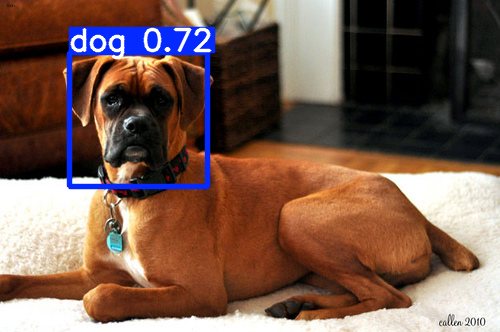

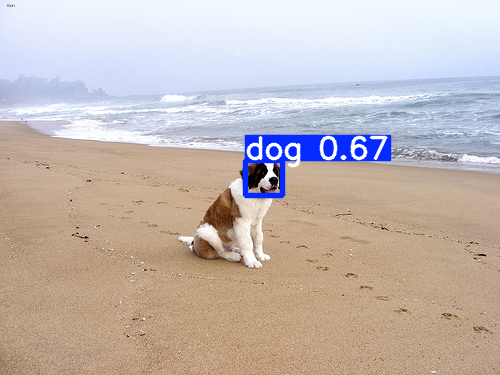

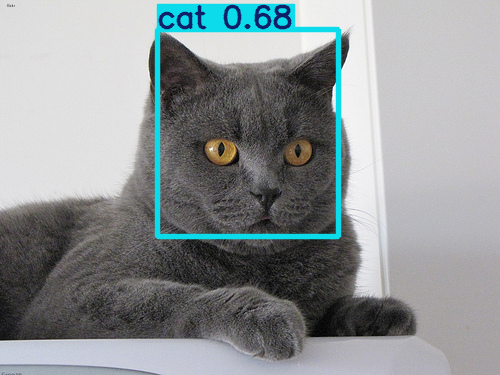

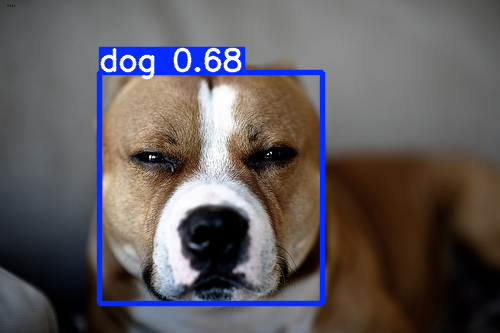

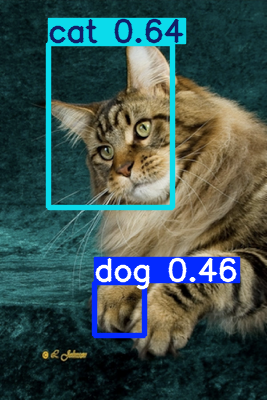

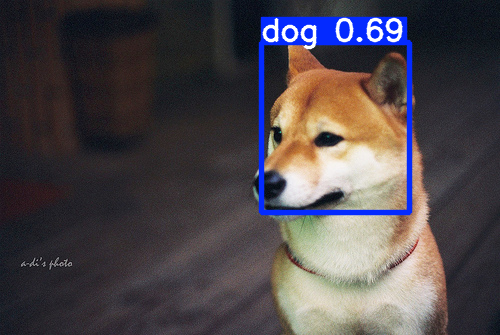

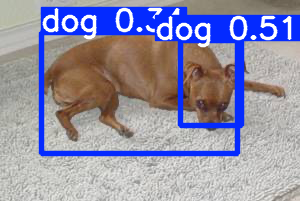

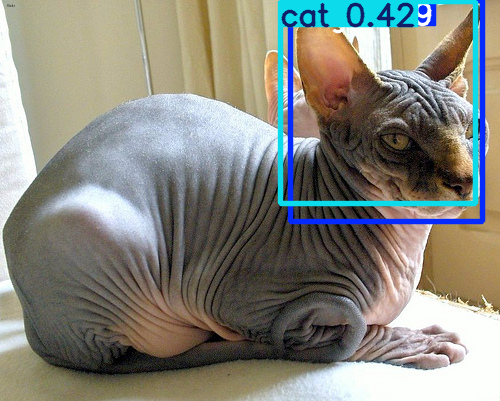

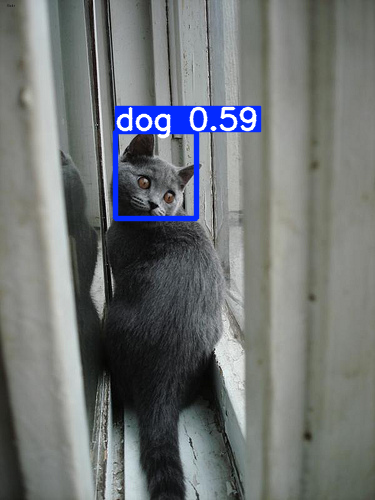

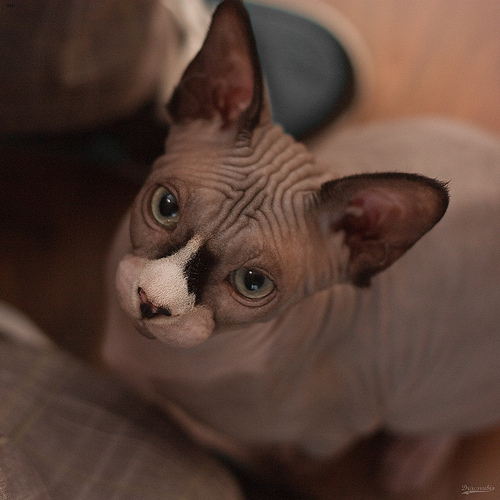

In [8]:
import glob
from IPython.display import display
from PIL import Image

# Get detected images
result_images = glob.glob("runs/detect/exp/*.png")

# Display first few images
for img_path in result_images[:10]:
    display(Image.open(img_path))

In [9]:
#open the loss.py file to see the existing loss function 
with open('/kaggle/working/yolov5/utils/loss.py', 'r') as file:
    original_loss = file.readlines()

In [10]:
# uncomment if you want to see the original loss 
#original_loss 

In [11]:
#copy the loss.py to another file to save the original file 
!cp /kaggle/working/yolov5/utils/loss.py /kaggle/working/original_loss.py


In [12]:
# New metric to incoperate the center allignment and the aspect ratio
def center_ar_metric_tensor(boxA, boxB, img_size=640):
    # Compute intersection area
    xA = torch.max(boxA[:, 0], boxB[:, 0])
    yA = torch.max(boxA[:, 1], boxB[:, 1])
    xB = torch.min(boxA[:, 2], boxB[:, 2])
    yB = torch.min(boxA[:, 3], boxB[:, 3])

    inter = (xB - xA).clamp(0) * (yB - yA).clamp(0)
    areaA = (boxA[:, 2] - boxA[:, 0]) * (boxA[:, 3] - boxA[:, 1])
    areaB = (boxB[:, 2] - boxB[:, 0]) * (boxB[:, 3] - boxB[:, 1])
    iou = inter / (areaA + areaB - inter + 1e-6)

    # === Compute center x and y differences ===
    cxA = (boxA[:, 0] + boxA[:, 2]) / 2
    cyA = (boxA[:, 1] + boxA[:, 3]) / 2
    cxB = (boxB[:, 0] + boxB[:, 2]) / 2
    cyB = (boxB[:, 1] + boxB[:, 3]) / 2

    dx = torch.abs(cxA - cxB)
    dy = torch.abs(cyA - cyB)

    # === Compute height/width ratios ===
    hA = boxA[:, 3] - boxA[:, 1]
    wA = boxA[:, 2] - boxA[:, 0]
    hB = boxB[:, 3] - boxB[:, 1]
    wB = boxB[:, 2] - boxB[:, 0]

    aspect_scale_x = torch.min(hA / (wA + 1e-6), hB / (wB + 1e-6))
    aspect_scale_y = torch.min(wA / (hA + 1e-6), wB / (hB + 1e-6))

    # === Compute scaled center differences ===
    # delta_c = (dx)* (aspect_scale_x )/ (img_size + 1e-6)+ (dy)*(aspect_scale_y )/ (img_size + 1e-6)
    delta_c = torch.sqrt((dx*aspect_scale_x)**2 +(dy*aspect_scale_y)**2) / np.sqrt(img_size**2 + img_size**2)
    # # === Aspect ratio difference ===
    arA = wA / (hA + 1e-6)
    arB = wB / (hB + 1e-6)
    delta_r = torch.abs(arA - arB) / (arA + arB + 1e-6)

    return 0.1* (1 - delta_c) +0.1*(1 - delta_r)


In [13]:
#define the new loss file content with the new loss term based on the new metric 
center_ar_loss_code='''


# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license
"""Loss functions."""

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from utils.metrics import bbox_iou
from utils.torch_utils import de_parallel


def smooth_BCE(eps=0.1):
    """Returns label smoothing BCE targets for reducing overfitting; pos: `1.0 - 0.5*eps`, neg: `0.5*eps`. For details see https://github.com/ultralytics/yolov3/issues/238#issuecomment-598028441."""
    return 1.0 - 0.5 * eps, 0.5 * eps


class BCEBlurWithLogitsLoss(nn.Module):
    """Modified BCEWithLogitsLoss to reduce missing label effects in YOLOv5 training with optional alpha smoothing."""

    def __init__(self, alpha=0.05):
        """Initializes a modified BCEWithLogitsLoss with reduced missing label effects, taking optional alpha smoothing
        parameter.
        """
        super().__init__()
        self.loss_fcn = nn.BCEWithLogitsLoss(reduction="none")  # must be nn.BCEWithLogitsLoss()
        self.alpha = alpha

    def forward(self, pred, true):
        """Computes modified BCE loss for YOLOv5 with reduced missing label effects, taking pred and true tensors,
        returns mean loss.
        """
        loss = self.loss_fcn(pred, true)
        pred = torch.sigmoid(pred)  # prob from logits
        dx = pred - true  # reduce only missing label effects
        # dx = (pred - true).abs()  # reduce missing label and false label effects
        alpha_factor = 1 - torch.exp((dx - 1) / (self.alpha + 1e-4))
        loss *= alpha_factor
        return loss.mean()


class FocalLoss(nn.Module):
    """Applies focal loss to address class imbalance by modifying BCEWithLogitsLoss with gamma and alpha parameters."""

    def __init__(self, loss_fcn, gamma=1.5, alpha=0.25):
        """Initializes FocalLoss with specified loss function, gamma, and alpha values; modifies loss reduction to
        'none'.
        """
        super().__init__()
        self.loss_fcn = loss_fcn  # must be nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = loss_fcn.reduction
        self.loss_fcn.reduction = "none"  # required to apply FL to each element

    def forward(self, pred, true):
        """Calculates the focal loss between predicted and true labels using a modified BCEWithLogitsLoss."""
        loss = self.loss_fcn(pred, true)
        # p_t = torch.exp(-loss)
        # loss *= self.alpha * (1.000001 - p_t) ** self.gamma  # non-zero power for gradient stability

        # TF implementation https://github.com/tensorflow/addons/blob/v0.7.1/tensorflow_addons/losses/focal_loss.py
        pred_prob = torch.sigmoid(pred)  # prob from logits
        p_t = true * pred_prob + (1 - true) * (1 - pred_prob)
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:  # 'none'
            return loss


class QFocalLoss(nn.Module):
    """Implements Quality Focal Loss to address class imbalance by modulating loss based on prediction confidence."""

    def __init__(self, loss_fcn, gamma=1.5, alpha=0.25):
        """Initializes Quality Focal Loss with given loss function, gamma, alpha; modifies reduction to 'none'."""
        super().__init__()
        self.loss_fcn = loss_fcn  # must be nn.BCEWithLogitsLoss()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = loss_fcn.reduction
        self.loss_fcn.reduction = "none"  # required to apply FL to each element

    def forward(self, pred, true):
        """Computes the focal loss between `pred` and `true` using BCEWithLogitsLoss, adjusting for imbalance with
        `gamma` and `alpha`.
        """
        loss = self.loss_fcn(pred, true)

        pred_prob = torch.sigmoid(pred)  # prob from logits
        alpha_factor = true * self.alpha + (1 - true) * (1 - self.alpha)
        modulating_factor = torch.abs(true - pred_prob) ** self.gamma
        loss *= alpha_factor * modulating_factor

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:  # 'none'
            return loss


#added the definition of new metric 
def center_ar_metric_tensor(boxA, boxB, img_size=640):
    # Compute intersection area
    xA = torch.max(boxA[:, 0], boxB[:, 0])
    yA = torch.max(boxA[:, 1], boxB[:, 1])
    xB = torch.min(boxA[:, 2], boxB[:, 2])
    yB = torch.min(boxA[:, 3], boxB[:, 3])

    inter = (xB - xA).clamp(0) * (yB - yA).clamp(0)
    areaA = (boxA[:, 2] - boxA[:, 0]) * (boxA[:, 3] - boxA[:, 1])
    areaB = (boxB[:, 2] - boxB[:, 0]) * (boxB[:, 3] - boxB[:, 1])
    iou = inter / (areaA + areaB - inter + 1e-6)

    # === Compute center x and y differences ===
    cxA = (boxA[:, 0] + boxA[:, 2]) / 2
    cyA = (boxA[:, 1] + boxA[:, 3]) / 2
    cxB = (boxB[:, 0] + boxB[:, 2]) / 2
    cyB = (boxB[:, 1] + boxB[:, 3]) / 2

    dx = torch.abs(cxA - cxB)
    dy = torch.abs(cyA - cyB)

    # === Compute height/width ratios ===
    hA = boxA[:, 3] - boxA[:, 1]
    wA = boxA[:, 2] - boxA[:, 0]
    hB = boxB[:, 3] - boxB[:, 1]
    wB = boxB[:, 2] - boxB[:, 0]

    aspect_scale_x = torch.min(hA / (wA + 1e-6), hB / (wB + 1e-6))
    aspect_scale_y = torch.min(wA / (hA + 1e-6), wB / (hB + 1e-6))

    # === Compute scaled center differences ===
    # delta_c = (dx)* (aspect_scale_x )/ (img_size + 1e-6)+ (dy)*(aspect_scale_y )/ (img_size + 1e-6)
    delta_c = torch.sqrt((dx*aspect_scale_x)**2 +(dy*aspect_scale_y)**2) / np.sqrt(img_size**2 + img_size**2)
    # # === Aspect ratio difference ===
    arA = wA / (hA + 1e-6)
    arB = wB / (hB + 1e-6)
    delta_r = torch.abs(arA - arB) / (arA + arB + 1e-6)

    return 0.1* (1 - delta_c) +0.1*(1 - delta_r)
    


def xywh2xyxy(x):
    y = x.clone()
    y[:, 0] = x[:, 0] - x[:, 2] / 2
    y[:, 1] = x[:, 1] - x[:, 3] / 2
    y[:, 2] = x[:, 0] + x[:, 2] / 2
    y[:, 3] = x[:, 1] + x[:, 3] / 2
    return y
class ComputeLoss:
    """Computes the total loss for YOLOv5 model predictions, including classification, box, and objectness losses."""

    sort_obj_iou = False

    # Compute losses
    def __init__(self, model, autobalance=False):
        """Initializes ComputeLoss with model and autobalance option, autobalances losses if True."""
        device = next(model.parameters()).device  # get model device
        h = model.hyp  # hyperparameters

        # Define criteria
        BCEcls = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([h["cls_pw"]], device=device))
        BCEobj = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([h["obj_pw"]], device=device))

        # Class label smoothing https://arxiv.org/pdf/1902.04103.pdf eqn 3
        self.cp, self.cn = smooth_BCE(eps=h.get("label_smoothing", 0.0))  # positive, negative BCE targets

        # Focal loss
        g = h["fl_gamma"]  # focal loss gamma
        if g > 0:
            BCEcls, BCEobj = FocalLoss(BCEcls, g), FocalLoss(BCEobj, g)

        m = de_parallel(model).model[-1]  # Detect() module
        self.balance = {3: [4.0, 1.0, 0.4]}.get(m.nl, [4.0, 1.0, 0.25, 0.06, 0.02])  # P3-P7
        self.ssi = list(m.stride).index(16) if autobalance else 0  # stride 16 index
        self.BCEcls, self.BCEobj, self.gr, self.hyp, self.autobalance = BCEcls, BCEobj, 1.0, h, autobalance
        self.na = m.na  # number of anchors
        self.nc = m.nc  # number of classes
        self.nl = m.nl  # number of layers
        self.anchors = m.anchors
        self.device = device

    def __call__(self, p, targets):  # predictions, targets
        """Performs forward pass, calculating class, box, and object loss for given predictions and targets."""
        lcls = torch.zeros(1, device=self.device)  # class loss
        lbox = torch.zeros(1, device=self.device)  # box loss
        lobj = torch.zeros(1, device=self.device)  # object loss
        tcls, tbox, indices, anchors = self.build_targets(p, targets)  # targets

        # Losses
        for i, pi in enumerate(p):  # layer index, layer predictions
            b, a, gj, gi = indices[i]  # image, anchor, gridy, gridx
            tobj = torch.zeros(pi.shape[:4], dtype=pi.dtype, device=self.device)  # target obj

            if n := b.shape[0]:
                # pxy, pwh, _, pcls = pi[b, a, gj, gi].tensor_split((2, 4, 5), dim=1)  # faster, requires torch 1.8.0
                pxy, pwh, _, pcls = pi[b, a, gj, gi].split((2, 2, 1, self.nc), 1)  # target-subset of predictions

                # Regression
                pxy = pxy.sigmoid() * 2 - 0.5
                pwh = (pwh.sigmoid() * 2) ** 2 * anchors[i]
                pbox = torch.cat((pxy, pwh), 1)  # predicted box
                iou = bbox_iou(pbox, tbox[i], CIoU=True).squeeze()  # iou(prediction, target)
                lbox += (1.0 - iou).mean()  # iou loss

                # Compute center_ar metric and combine
                boxA = xywh2xyxy(pbox)
                boxB = xywh2xyxy(tbox[i])
                center_ar_score = center_ar_metric_tensor(boxA, boxB)
                center_ar_loss = (1.0 - center_ar_score).mean()

                #new loss term based on the center_ar_metric added

                lbox += center_ar_loss  # Add center_ar_loss as extra term

                # Objectness
                iou = iou.detach().clamp(0).type(tobj.dtype)
                if self.sort_obj_iou:
                    j = iou.argsort()
                    b, a, gj, gi, iou = b[j], a[j], gj[j], gi[j], iou[j]
                if self.gr < 1:
                    iou = (1.0 - self.gr) + self.gr * iou
                tobj[b, a, gj, gi] = iou  # iou ratio

                # Classification
                if self.nc > 1:  # cls loss (only if multiple classes)
                    t = torch.full_like(pcls, self.cn, device=self.device)  # targets
                    t[range(n), tcls[i]] = self.cp
                    lcls += self.BCEcls(pcls, t)  # BCE

            obji = self.BCEobj(pi[..., 4], tobj)
            lobj += obji * self.balance[i]  # obj loss
            if self.autobalance:
                self.balance[i] = self.balance[i] * 0.9999 + 0.0001 / obji.detach().item()

        if self.autobalance:
            self.balance = [x / self.balance[self.ssi] for x in self.balance]
        lbox *= self.hyp["box"]
        lobj *= self.hyp["obj"]
        lcls *= self.hyp["cls"]
        bs = tobj.shape[0]  # batch size

        return (lbox + lobj + lcls) * bs, torch.cat((lbox, lobj, lcls)).detach()

    def build_targets(self, p, targets):
        """Prepares model targets from input targets (image,class,x,y,w,h) for loss computation, returning class, box,
        indices, and anchors.
        """
        na, nt = self.na, targets.shape[0]  # number of anchors, targets
        tcls, tbox, indices, anch = [], [], [], []
        gain = torch.ones(7, device=self.device)  # normalized to gridspace gain
        ai = torch.arange(na, device=self.device).float().view(na, 1).repeat(1, nt)  # same as .repeat_interleave(nt)
        targets = torch.cat((targets.repeat(na, 1, 1), ai[..., None]), 2)  # append anchor indices

        g = 0.5  # bias
        off = (
            torch.tensor(
                [
                    [0, 0],
                    [1, 0],
                    [0, 1],
                    [-1, 0],
                    [0, -1],  # j,k,l,m
                    # [1, 1], [1, -1], [-1, 1], [-1, -1],  # jk,jm,lk,lm
                ],
                device=self.device,
            ).float()
            * g
        )  # offsets

        for i in range(self.nl):
            anchors, shape = self.anchors[i], p[i].shape
            gain[2:6] = torch.tensor(shape)[[3, 2, 3, 2]]  # xyxy gain

            # Match targets to anchors
            t = targets * gain  # shape(3,n,7)
            if nt:
                # Matches
                r = t[..., 4:6] / anchors[:, None]  # wh ratio
                j = torch.max(r, 1 / r).max(2)[0] < self.hyp["anchor_t"]  # compare
                # j = wh_iou(anchors, t[:, 4:6]) > model.hyp['iou_t']  # iou(3,n)=wh_iou(anchors(3,2), gwh(n,2))
                t = t[j]  # filter

                # Offsets
                gxy = t[:, 2:4]  # grid xy
                gxi = gain[[2, 3]] - gxy  # inverse
                j, k = ((gxy % 1 < g) & (gxy > 1)).T
                l, m = ((gxi % 1 < g) & (gxi > 1)).T
                j = torch.stack((torch.ones_like(j), j, k, l, m))
                t = t.repeat((5, 1, 1))[j]
                offsets = (torch.zeros_like(gxy)[None] + off[:, None])[j]
            else:
                t = targets[0]
                offsets = 0

            # Define
            bc, gxy, gwh, a = t.chunk(4, 1)  # (image, class), grid xy, grid wh, anchors
            a, (b, c) = a.long().view(-1), bc.long().T  # anchors, image, class
            gij = (gxy - offsets).long()
            gi, gj = gij.T  # grid indices

            # Append
            indices.append((b, a, gj.clamp_(0, shape[2] - 1), gi.clamp_(0, shape[3] - 1)))  # image, anchor, grid
            tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
            anch.append(anchors[a])  # anchors
            tcls.append(c)  # class

        return tcls, tbox, indices, anch

   
'''
#write the content to loss.py to modify the training process
with open("/kaggle/working/yolov5/utils/loss.py", "w") as f:
    f.write(center_ar_loss_code)

In [14]:
#Run the training with new loss function (loss function with new metric)
!python train.py --img 640 --batch 16 --epochs 10 --data ../cats_dogs.yaml --weights yolov5s.pt --name catdog_run_center_ar

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-10 09:32:44.179650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 09:32:44.201647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 09:32:44.208221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

In [15]:
!python detect.py --weights /kaggle/working/yolov5/runs/train/catdog_run_center_ar/weights/best.pt --img 640 --source /kaggle/working/catsdogs/images/val_new --conf 0.25 --save-txt --save-conf

detect: weights=['/kaggle/working/yolov5/runs/train/catdog_run_center_ar/weights/best.pt'], source=/kaggle/working/catsdogs/images/val_new, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/100 /kaggle/working/catsdogs/images/val_new/Cats_Test1038.png: 640x480 2 cats, 29.1ms
image 2/100 /kaggle/working/catsdogs/images/val_new/Cats_Test104.png: 448x640 1 cat, 30.5ms
image 3/100 /kaggle/working/catsdogs/images/val_new/Cats_Test1063.png:

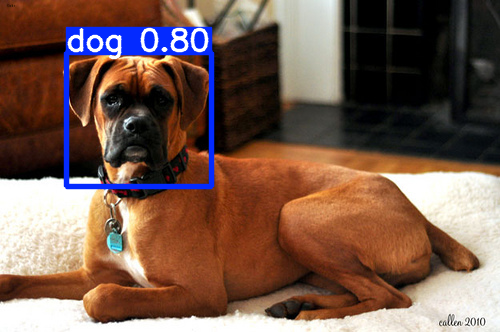

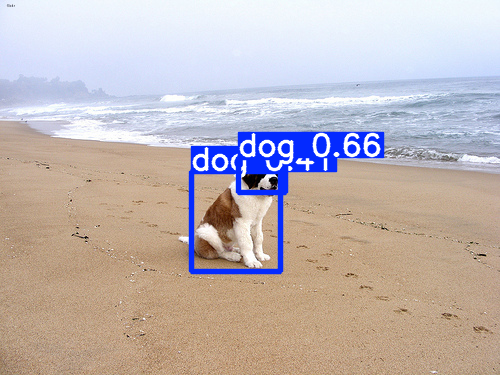

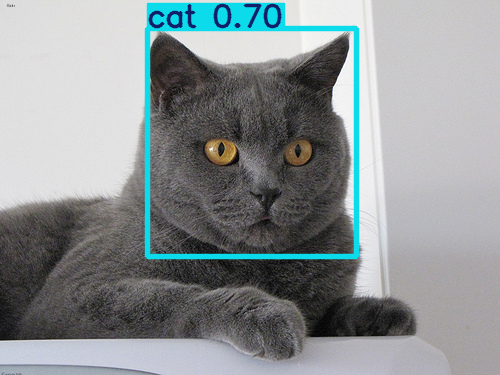

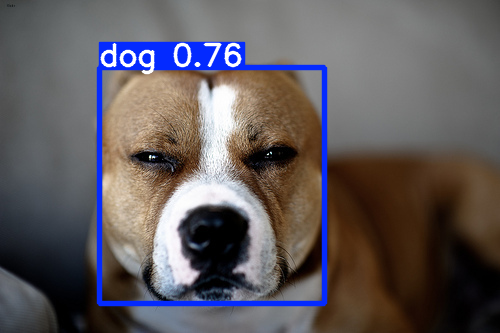

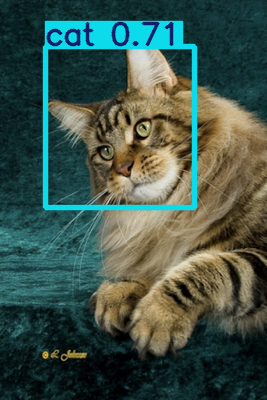

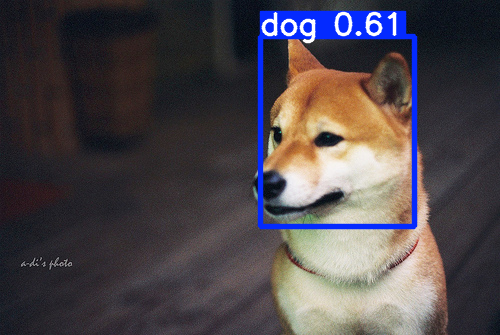

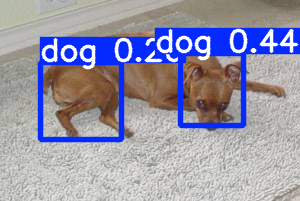

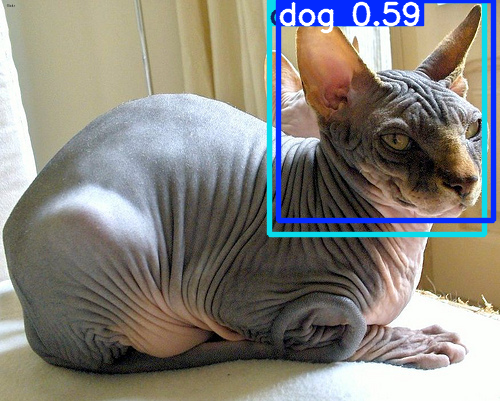

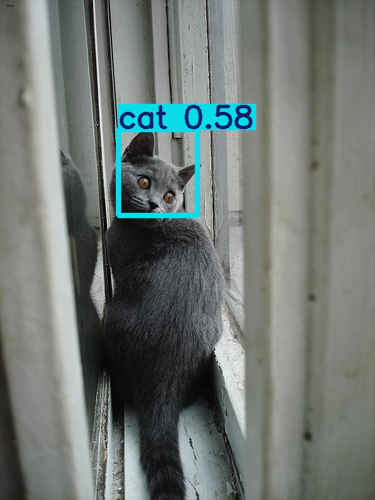

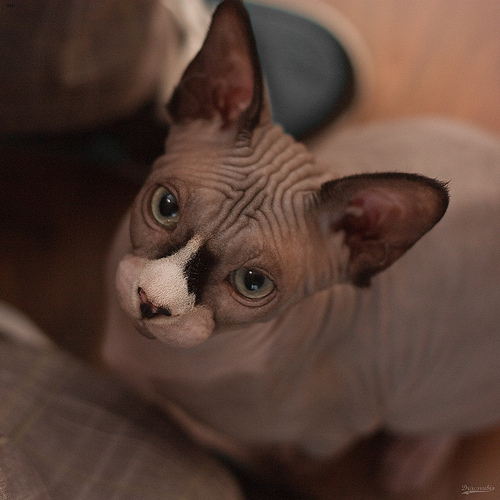

In [16]:
import glob
from IPython.display import display
from PIL import Image

# Get detected images
result_images = glob.glob("runs/detect/exp2/*.png")

# Display first few images
for img_path in result_images[:10]:
    display(Image.open(img_path))

In [19]:
#metrics of original loss
import pandas as pd

# Load training results
results_df = pd.read_csv("/kaggle/working/yolov5/runs/train/catdog_run_original/results.csv")

# Display the first few rows
print(results_df.head())

                  epoch        train/box_loss        train/obj_loss  \
0                     0              0.104730              0.029381   
1                     1              0.069679              0.026806   
2                     2              0.062763              0.022665   
3                     3              0.058000              0.021741   
4                     4              0.051524              0.020313   

         train/cls_loss     metrics/precision        metrics/recall  \
0              0.028841              0.003141               0.96992   
1              0.023321              0.593520               0.28061   
2              0.019045              0.756560               0.24627   
3              0.014386              0.530310               0.60086   
4              0.012672              0.541960               0.55485   

        metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
0              0.017253              0.004163              0.056468   
1   

In [20]:
#metrics of new loss
import pandas as pd

# Load training results
results_df = pd.read_csv("/kaggle/working/yolov5/runs/train/catdog_run_center_ar/results.csv")

# Display the first few rows
print(results_df.head())

                  epoch        train/box_loss        train/obj_loss  \
0                     0               0.22975              0.029637   
1                     1               0.19161              0.027308   
2                     2               0.18238              0.023175   
3                     3               0.18047              0.022037   
4                     4               0.17415              0.020593   

         train/cls_loss     metrics/precision        metrics/recall  \
0              0.028931               0.00318               0.98507   
1              0.023453               0.31562               0.25457   
2              0.019269               0.71098               0.21642   
3              0.015218               0.44031               0.60018   
4              0.013443               0.59973               0.56313   

        metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
0              0.012837              0.003444               0.15772   
1   

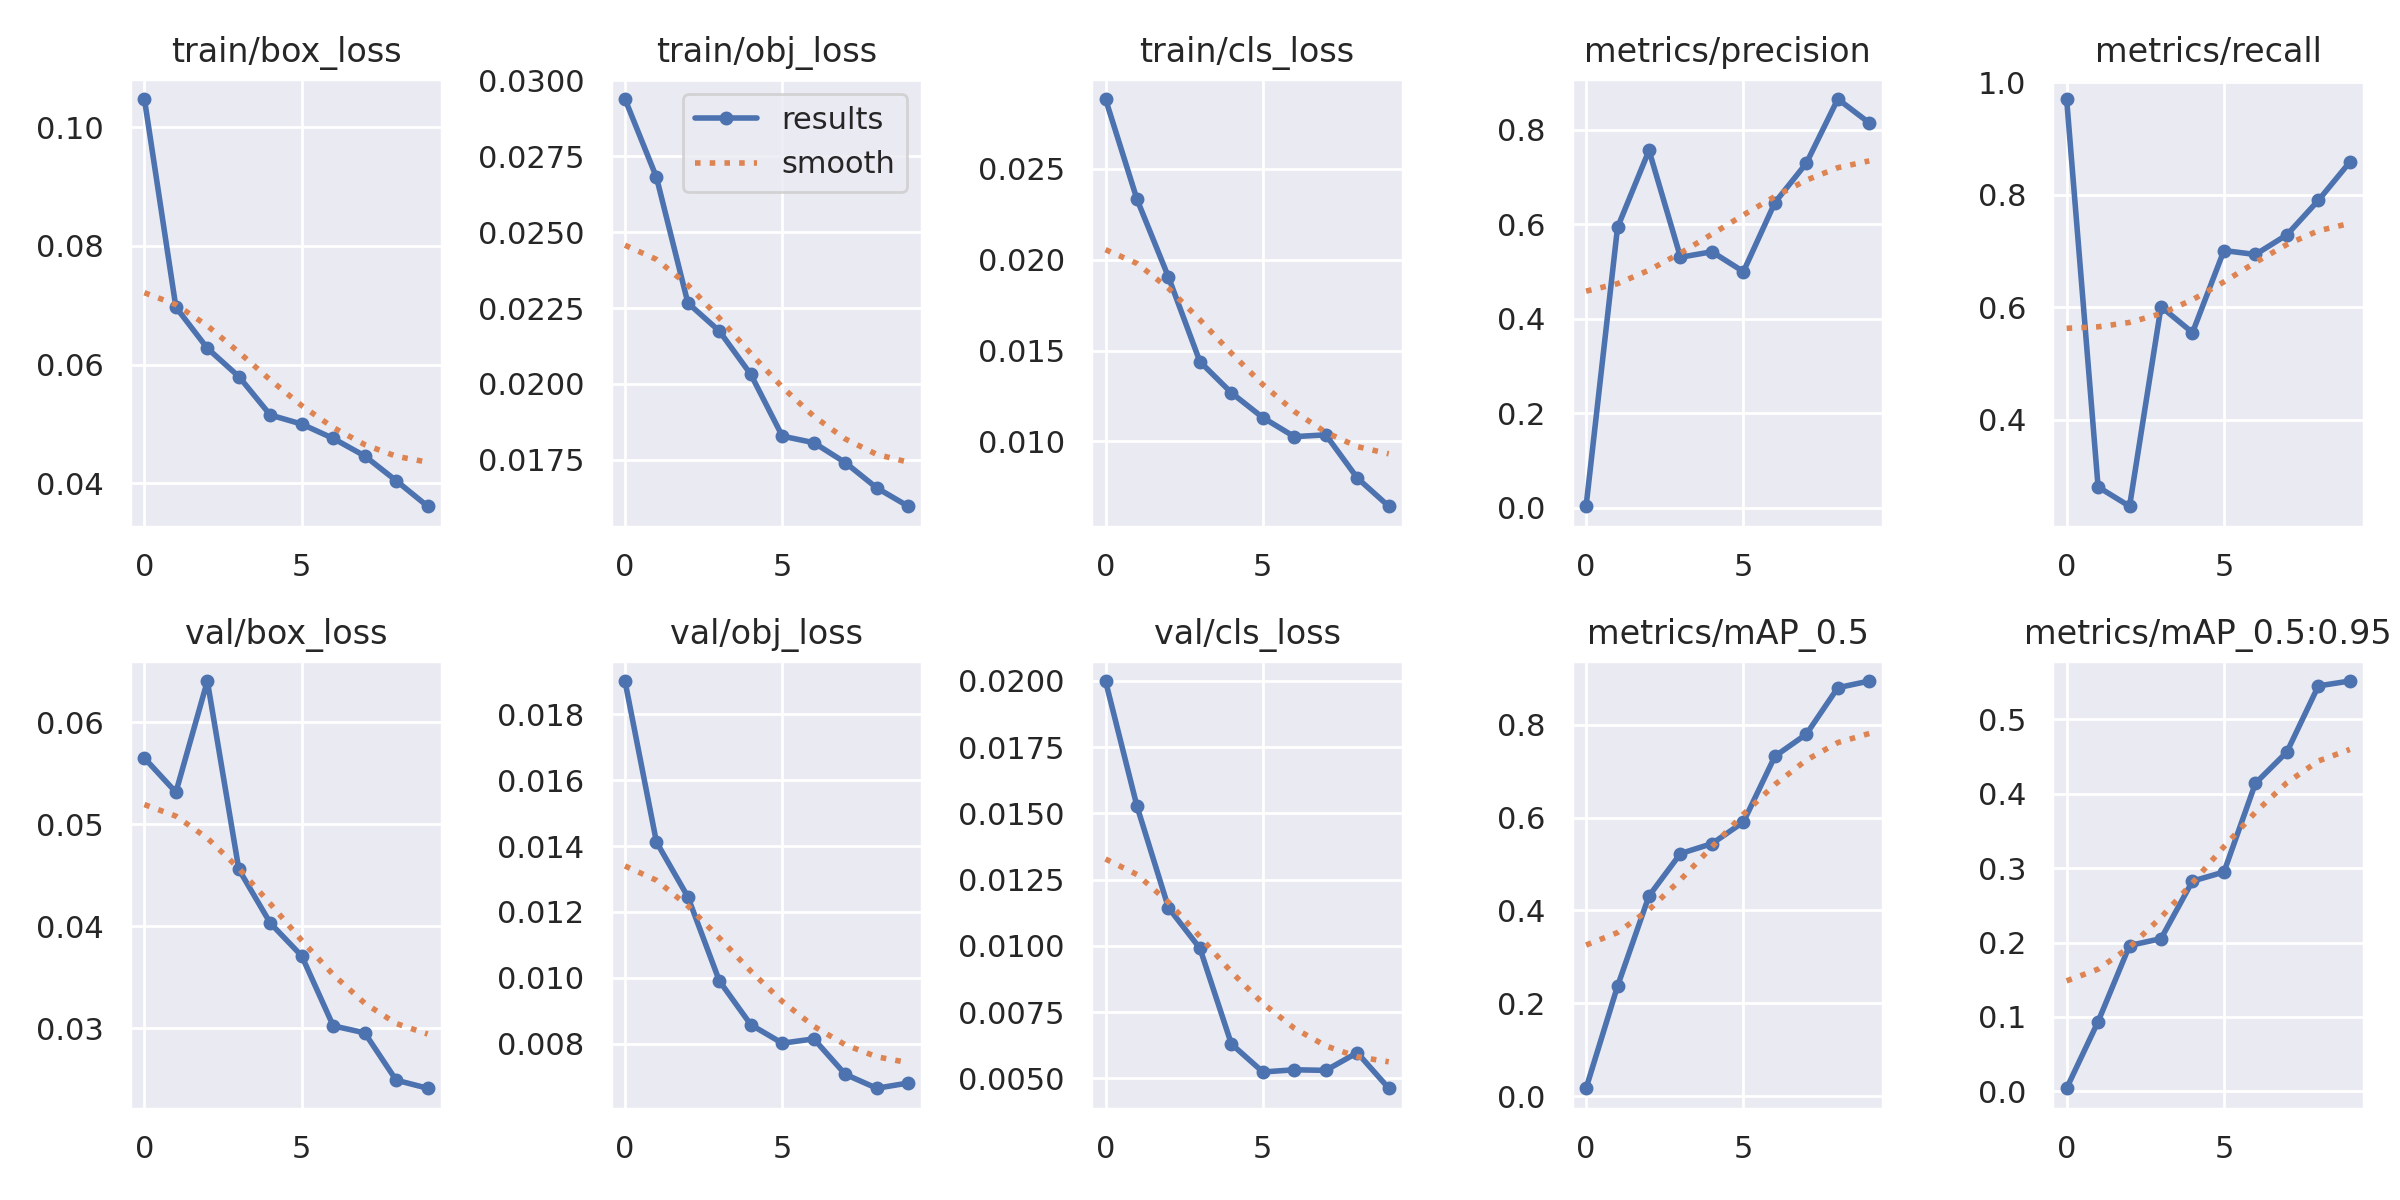

In [21]:
from IPython.display import Image
Image(filename='/kaggle/working/yolov5/runs/train/catdog_run_original/results.png')

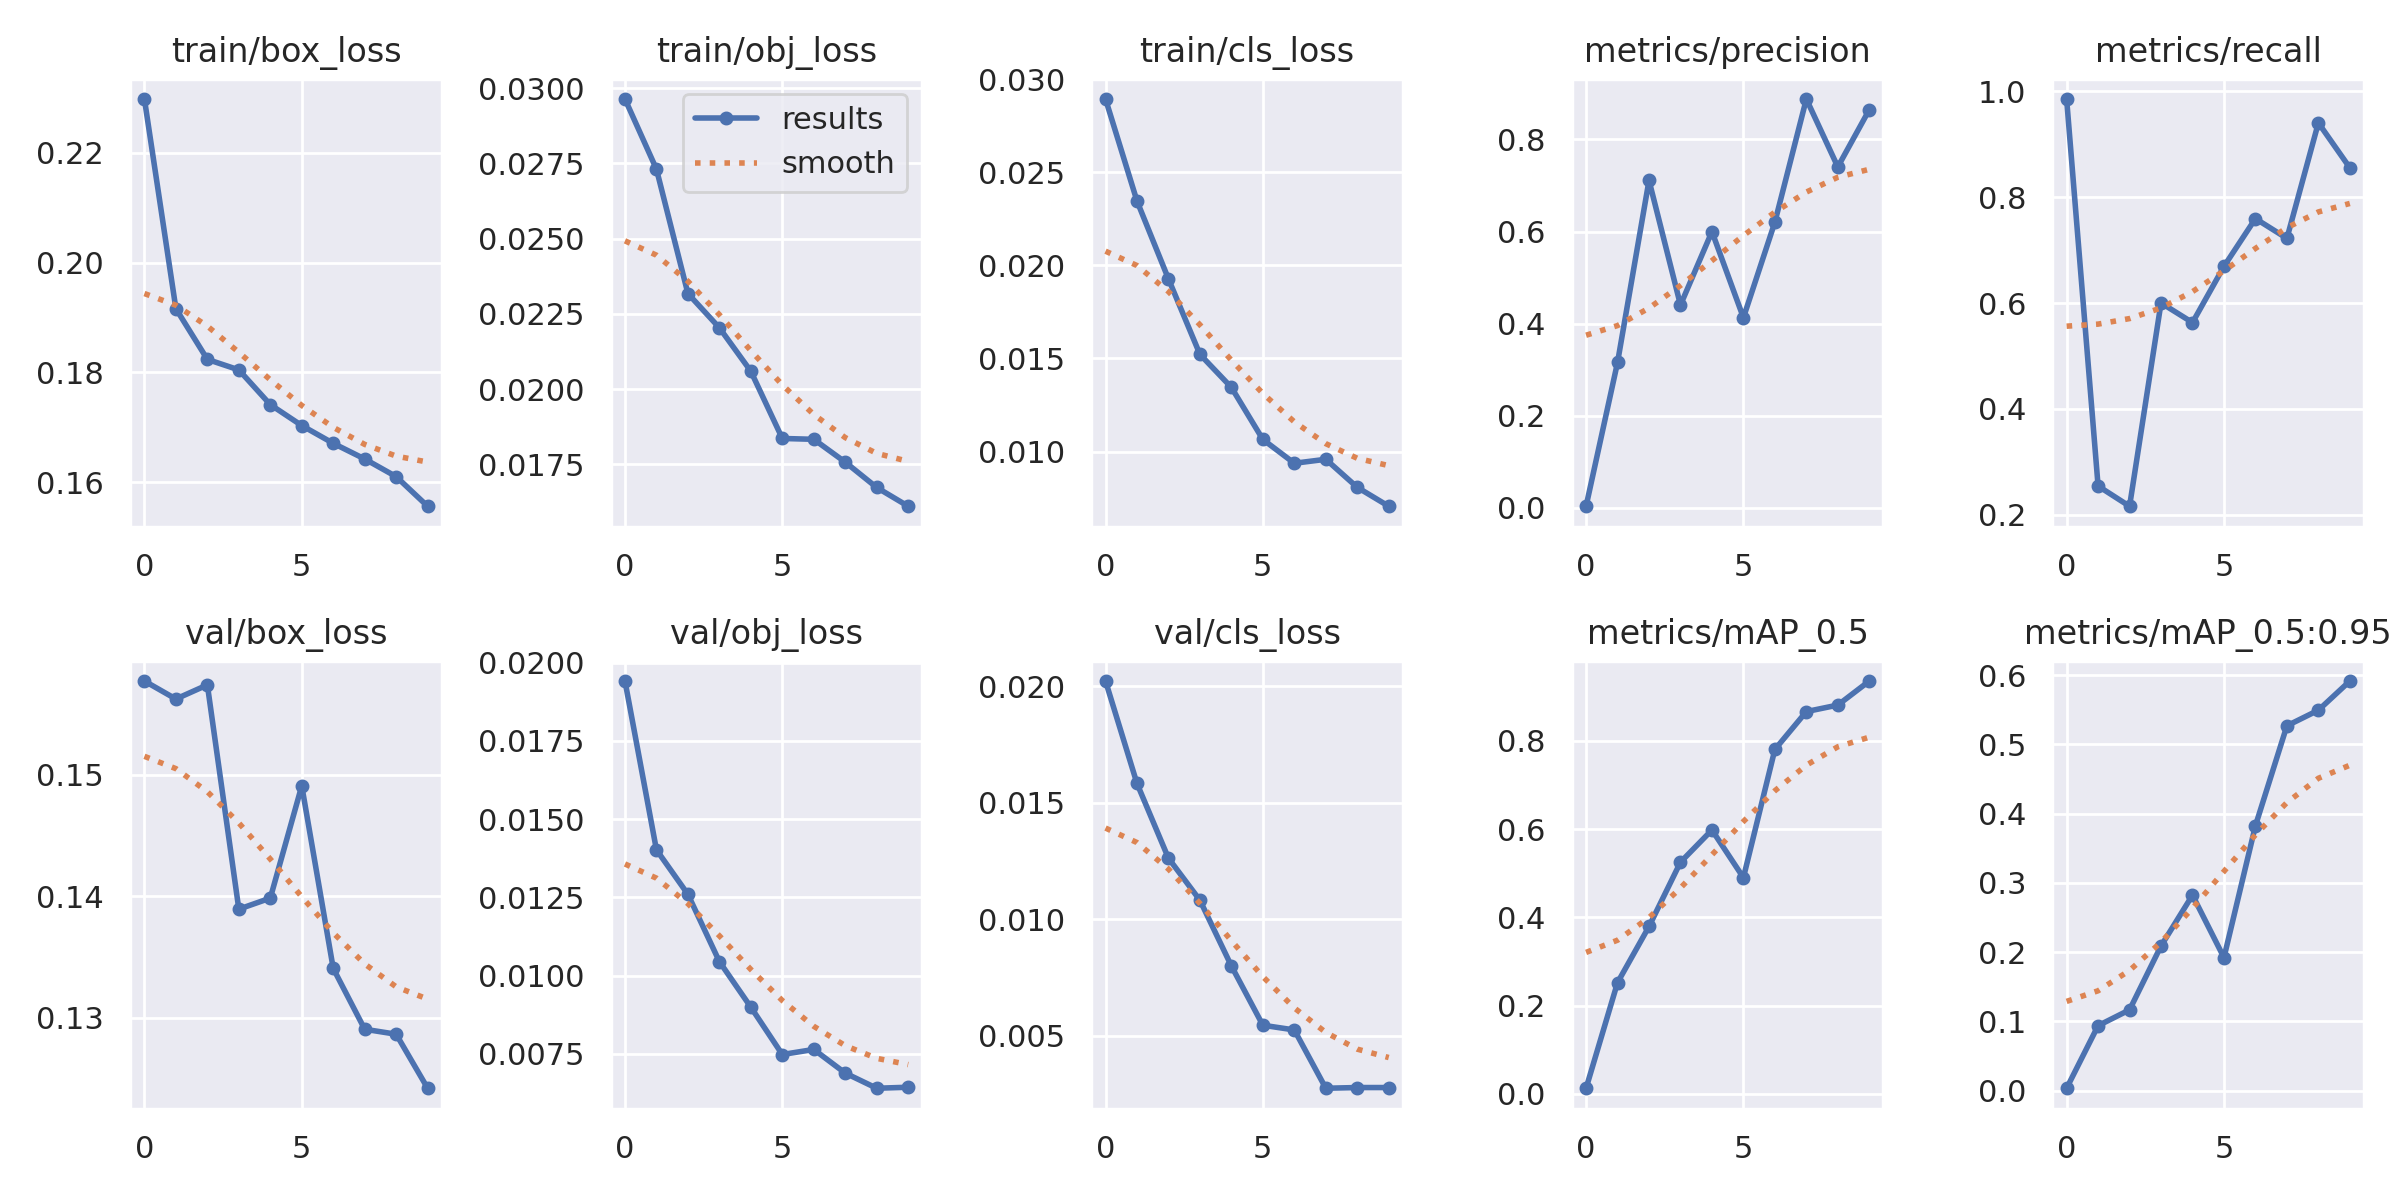

In [22]:
from IPython.display import Image
Image(filename='/kaggle/working/yolov5/runs/train/catdog_run_center_ar/results.png')

In [2]:
import os
from pathlib import Path
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from collections import defaultdict

# === Your custom metric ===
def center_ar_metric_tensor(boxA, boxB, img_size=640):
    xA = torch.max(boxA[:, 0], boxB[:, 0])
    yA = torch.max(boxA[:, 1], boxB[:, 1])
    xB = torch.min(boxA[:, 2], boxB[:, 2])
    yB = torch.min(boxA[:, 3], boxB[:, 3])
    inter = (xB - xA).clamp(0) * (yB - yA).clamp(0)
    areaA = (boxA[:, 2] - boxA[:, 0]) * (boxA[:, 3] - boxA[:, 1])
    areaB = (boxB[:, 2] - boxB[:, 0]) * (boxB[:, 3] - boxB[:, 1])
    iou = inter / (areaA + areaB - inter + 1e-6)

    cxA = (boxA[:, 0] + boxA[:, 2]) / 2
    cyA = (boxA[:, 1] + boxA[:, 3]) / 2
    cxB = (boxB[:, 0] + boxB[:, 2]) / 2
    cyB = (boxB[:, 1] + boxB[:, 3]) / 2
    dx = torch.abs(cxA - cxB)
    dy = torch.abs(cyA - cyB)

    hA = boxA[:, 3] - boxA[:, 1]
    wA = boxA[:, 2] - boxA[:, 0]
    hB = boxB[:, 3] - boxB[:, 1]
    wB = boxB[:, 2] - boxB[:, 0]

    aspect_scale_x = torch.min(hA / (wA + 1e-6), hB / (wB + 1e-6))
    aspect_scale_y = torch.min(wA / (hA + 1e-6), wB / (hB + 1e-6))

    delta_c = torch.sqrt((dx*aspect_scale_x)**2 + (dy*aspect_scale_y)**2) / np.sqrt(img_size**2 + img_size**2)
    arA = wA / (hA + 1e-6)
    arB = wB / (hB + 1e-6)
    delta_r = torch.abs(arA - arB) / (arA + arB + 1e-6)

    return 0.1 * (1 - delta_c) + 0.1 * (1 - delta_r), iou


# === Helper to convert YOLO to xyxy ===
def yolo_to_xyxy(box, img_w=640, img_h=640):
    x_c, y_c, w, h = box[:4]
    x1 = (x_c - w / 2) * img_w
    y1 = (y_c - h / 2) * img_h
    x2 = (x_c + w / 2) * img_w
    y2 = (y_c + h / 2) * img_h
    return [x1, y1, x2, y2]

# === Paths ===
pred_dir = Path("/kaggle/working/yolov5/runs/detect/exp2/labels")  # YOLOv5 validation predictions
gt_dir = Path("/kaggle/working/catsdogs/labels/val_new")             # Ground truth labels (same naming)

# === Metric Containers ===
all_ious = []
all_custom = []
all_y_true = []
all_y_scores = defaultdict(list)

# === Loop Through Files ===
for pred_file in pred_dir.glob("*.txt"):
    gt_file = gt_dir / pred_file.name
    if not gt_file.exists():
        continue

    with open(pred_file) as f:
        preds = [list(map(float, line.strip().split())) for line in f.readlines()]

    with open(gt_file) as f:
        gts = [list(map(float, line.strip().split())) for line in f.readlines()]

    # Match each prediction to best ground truth
    for pred in preds:
        pred_cls, *pred_box = pred
        pred_xyxy = torch.tensor([yolo_to_xyxy(pred_box)]).float()

        best_iou = 0
        best_score = 0
        matched = False

        for gt in gts:
            gt_cls, *gt_box = gt
            gt_xyxy = torch.tensor([yolo_to_xyxy(gt_box)]).float()

            score, iou = center_ar_metric_tensor(pred_xyxy, gt_xyxy)
            if iou >= 0.5 and int(pred_cls) == int(gt_cls):
                best_iou = max(best_iou, iou.item())
                best_score = max(best_score, score.item())
                matched = True

        all_ious.append(best_iou)
        all_custom.append(best_score)
        all_y_true.append(1 if matched else 0)
        all_y_scores[int(pred_cls)].append(best_score)

# === Print Results ===
print(f"\n Mean IoU: {np.mean(all_ious):.4f}")
print(f" Mean Custom Metric: {np.mean(all_custom):.4f}")

# === mAP (basic estimate at IoU 0.5, class-agnostic) ===
print("\n  mAP (IoU ≥ 0.5)...")
y_pred = all_custom  # or could use confidence if available
map_score = average_precision_score(all_y_true, y_pred)
print(f" mAP@0.5 (approx): {map_score:.4f}")



 Mean IoU: nan
 Mean Custom Metric: nan

  mAP (IoU ≥ 0.5)...


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: cannot do a non-empty take from an empty axes.